In [5]:
import ConvexSampling
using .ConvexSampling
using LinearAlgebra
using Plots
using Test

┌ Info: Precompiling ConvexSampling [11d2b6ea-33ce-4b4d-a547-2ef600a65ac9]
└ @ Base loading.jl:1664


# convex-sampling

In [our recent paper](https://doi.org/10.1016/j.compchemeng.2021.107413), we presented a new approach for generating a guaranteed affine underestimator for a black-box convex function on a box domain, by tractable derivative-free sampling.
In this repository, the `SamplingUnderestimators` module in [SamplingUnderestimators.jl](src/SamplingUnderestimators.jl) provides a Julia implementation  of our new sampling approach, along with an experimental approach that uses fewer samples.

This implementation uses `Plots.jl` to generate plots. Tested in Julia v.1.7. Primarily written by Maha Chaudhry.

## Method outline

Suppose we have a convex function `f` of `n` variables, defined on a box domain `X = [xL, xU]`. Our [new underestimating approach](https://doi.org/10.1016/j.compchemeng.2021.107413) samples `f` at `2n+1` domain points: the midpoint of `X`, and perturbations of this midpoint in each positive/negative coordinate direction. These sampled values are then tractably assembled using new finite difference formulas to yield guaranteed affine underestimators and guaranteed lower bounds for `f` on `X`. These underestimators are guaranteed by convex analysis theory; roughly, the sampled information is sufficient to infer a compact polyhedral set that encloses all subgradients of `f` at the midpoint of `X`. Using this information, we can deduce the "worst-case" convex functions that are consistent with the sampled data.

As in our paper, this implementation also allows for absolute error in evaluating `f`, and for off-center sampling stencils. When `n=1`, we additionally exploit the fact that each domain point is collinear with all three sampled points.

An experimental new procedure is also implemented, requiring `n+2` samples instead of `2n+1` samples.

## Exported functions

The module `SamplingUnderestimators` exports several functions, with the following common inputs:

- `f::Function`: the convex function to be sampled and underestimated.
  - Must have either the signature `f(x::Vector{Float64})::Float64` or `f(x::Float64)::Float64`.
  - Must be convex, otherwise the generated results will be meaningless; our implementation treats `f` as a black box and cannot verify convexity.
  - In the remainder of this section, `T` will denote the type of `f`'s input (either `Vector{Float64}` or `Float64`).

- `xL::T` and `xU::T`: specify the box domain on which `f` is defined. A vector `x` is considered to be inside this box if `xL<=x<=xU`.

The following functions are exported by `SamplingUnderestimators`:

- `(w0::T, b::T, c::Float64, sR::T) = eval_sampling_underestimator_coeffs(f, xL, xU)`:
  - evaluates coefficients for which the affine function `x -> c + dot(b, x - w0)` is guaranteed to underestimate `f` on `[xL, xU]`.
  - The function `f` is sampled `2n+1` times by default.
  - The additional output `sR` is only used by our experimental method that samples `f` fewer times.

- `fAffine::Function = construct_sampling_underestimator(f, xL, xU)`
  - same as `eval_sampling_underestimator_coeffs`, except that the underestimator function `fAffine(x) = c + dot(b, x - w0)` is returned.

- `yOut::Float64 = eval_sampling_underestimator(f, xL, xU, xIn::T)`
  - evaluates the underestimator `fAffine` constructed by `construct_sampling_underestimator` at a domain point `xIn`. That is, `yOut = fAffine(xIn)`.

-  `fL::Float64 = eval_sampling_lower_bound(f, xL, xU)`:
    - computes a lower bound `fL` of `f` on the box `[xL, xU]`, so that `f(x) >= fL` for each `x` in the box.

-  `plot_sampling_underestimator(f::Function, xL::Vector{Float64}, xU::Vector{Float64}; plot3DStyle::Vector = [surface!, wireframe!, surface], fEvalResolution::Int64 = 10)`
    -  plots `f`, its affine underestimator `fAffine`, and its lower bound `fL`, on the box domain `[xL, xU]`. `f` must be a function of either `1` or `2` variables, and must take a `Vector{Float64}` input.
    - The key argument `plot3DStyle` sets the plot style (ex. wireframe, surface, etc.) of each individual plot component in the set order: (1) lower bound, (2) affine under-estimator, (3) convex function.
    - The key argument `fEvalResolution` is the number of mesh rows per domain dimension in the resulting plot.
    - The produced graph may be stored to a variable and later retrieved with `@show`; see example below.

### Key arguments

All exported functions also include the following optional keyword arguments, with indicated default values:
- `samplingPolicy::SamplingType`:
  - Determines the sampling strategy and the number of evaluations of `f`. Possible values:
  - `SAMPLE_COMPASS_STAR` (default),  uses `(2n+1)` function evaluations in a compass-star stencil.
  - `SAMPLE_SIMPLEX_STAR` uses `(n+2)` evaluations instead in a simplex-star stencil. This is experimental, and does not currently utilize `lambda` or `epsilon`.
- `alpha::Vector{Float64}`:
  - The dimensionless step length of each sampled point from the stencil center `w0`. All components of alpha must be between `(0.0, 1.0 - lambda]`; each is set to `0.1` by default. If the step length is too small, then subtraction operations in our finite difference formulas might cause unacceptable numerical error.
- `lambda::Vector{Float64}`:
  - An offset for the location of `w0` to employ sampling stencils where `w0` is not the domain midpoint. All components of `lambda` must be between `(-1.0, 1.0)`, and are `0.0` by default.
- `epsilon::Float64`:
  - An absolute error bound for evaluations of `f` we presume that each numerical evaluation of `f(x)` is within `epsilon` of the correct value. Set to `0.0` by default.

## Example

The usage of `SamplingUnderestimators` is demonstrated by script [testConvex.jl](test/testConvex.jl).
Consider the following convex quadratic function of two variables within a box domain of `xL = [-5.0, -3.0]` and `xU = [5.0, 3.0]`:

In [6]:
f(x) = dot(x, [65.0 56.0; 56.0 65.0], x) + dot([6.0, 2.0], x) + 23.0

f (generic function with 1 method)

Using the `SamplingUnderestimators` module (after commands `include(“ConvexSampling.jl”)` and `using .SamplingUnderestimators`), we can evaluate its affine underestimator at an input value of `x = [2.0, 2.0]`.
- By defining f beforehand:

In [7]:
yOutput = eval_sampling_underestimator(f, [-5.0, -3.0], [5.0, 3.0], [2.0, 2.0])

-182.0

- By defining f as an anonymous function:

In [8]:
yOutput = eval_sampling_underestimator([-5.0, -3.0], [5.0, 3.0], [2.0, 2.0]) do x
    dot(x,[65 56; 56 65], x) + dot([6;2], x) + 23
end

-182.0

- By constructing the underestimator as a function, and then evaluating it:

In [23]:
fAffine() = construct_sampling_underestimator(f, [-5.0, -3.0], [5.0, 3.0])
yOutput = fAffine()
yOutput([2.0,2.0])

-182.0

Contructing the underestimator is worthwhile if you plan on evaluating it at more than one `x`-value.

The function `f` may be plotted with its sampling-based underestimator `fAffine` and lower bound `fL`:

graph = Plot{Plots.GRBackend() n=4}


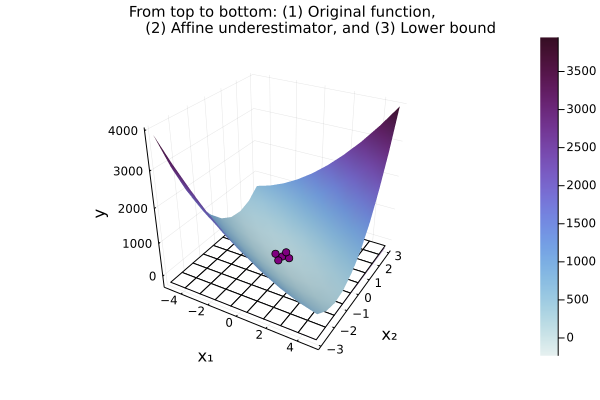

┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\maha-\.julia\packages\Plots\lW9ll\src\backends\gr.jl:520


In [11]:
graph = plot_sampling_underestimator(f, [-5.0, -3.0], [5.0, 3.0])
@show graph

Note that if the `plot_sampling_underestimator` function is entered directly into the command window, the `@show` command is not required.

# References

- Yingkai Song, Huiyi Cao, Chiral Mehta, and Kamil A. Khan, [Bounding convex relaxations of process models from below by tractable black-box sampling]( https://doi.org/10.1016/j.compchemeng.2021.107413), _Computers & Chemical Engineering_, 153:107413, 2021, DOI: 10.1016/j.compchemeng.2021.107413